<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/TP4/GENTIEU_GOUESSE_TP4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin et GOUESSE Sixtine : TP4


## Détection des anomalies de trajectoire

### Etape 1 : Préparation de l'environnement

Installation du projet : Sur Google Colab :
Allez dans le terminal et exécutez :
```bash
git clone https://github.com/MGentieu/Data_analytics_aircraft_messages.git
```

## PARTIE 1 — Chargement du dataset et exploration  

### On se place dans un premier temps dans le répertoire parent

In [1]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

if cwd.name == "content": #Si vous êtes sur Colab
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "data_analytics_aircraft_messages" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'data_analytics_aircraft_messages' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]/"TP4"
else: #Si vous êtes en local, donc dans le dossier TP4. On se place alors sur le répertoire parent.
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: C:\Users\33695\Documents\Data_analytics_aircraft_messages\TP4
Setup complete.


On installe ensuite les librairies. Si vous êtes sur un environnement local, assurez-vous d'avoir un environnement virtuel activé.

Par exemple : Commandes à faire avec Windows PowerShell :
`bash
python -m venv .venv
.venv\Scripts\Activate`


Si vous êtes sur Google Colab, pas besoin

Ensuite, que vous soyez en local ou sur colab, exécutez la cellule suivante :

In [2]:
%pip install -r {PROJECT_ROOT/'requirements_TP4.txt'}

  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Using cached fastjsonschema-2.21.2-py3-none-any.whl.metadata (2.3 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached attrs-25.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached referencing-0.37.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached rpds_py-0.30.0-cp312-cp312-win_amd64.whl.metadata (4.2 kB)
Using cached nbformat-5.10.4-py3-none-any.whl (78 kB)
Using cached fastjsonschema-2.21.2-py3-none-any.whl (24 kB)
Using cached jsonschema-4.25.1-py3-none-any.whl (90 kB)
Using cached attrs-25.4.0-py3-none-any.whl (67 kB)
Using cached jsonschema_specifications-2025.9.1-py3-none-any.whl (18 kB)
Using cached referencing-0.37.0-py3-none-any.whl (26 kB)
Using cached rpds_py-0.30.0-cp312-cp312-win_amd64.whl (240 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


### On importe ensuite les bibliothèques nécessaires à l'analyse :

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime
import random

### On charge notre dataset et on fait une analyse primaire

In [4]:
df = pd.read_csv(f"{PROJECT_ROOT}/dataset_trajectoires_anomalies.csv")

On affiche les premières lignes de notre dataset

In [5]:
df.head()

,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159


Cela permet d’avoir un aperçu des colonnes : latitude, longitude, altitude, vitesse, anomaly_type, flight_id, timestamp, etc.

On affiche les colonnes et leurs informations de notre dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13500 entries, 0 to 13499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   flight_id       13500 non-null  object 
 1   anomaly_type    13500 non-null  object 
 2   timestamp       13500 non-null  object 
 3   latitude        13500 non-null  float64
 4   longitude       13500 non-null  float64
 5   altitude        13500 non-null  float64
 6   ground_speed    13500 non-null  int64  
 7   vertical_speed  13500 non-null  int64  
 8   heading         13500 non-null  int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 949.3+ KB


In [7]:
df.describe()

,latitude,longitude,altitude,ground_speed,vertical_speed,heading
count,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000,13500.000000
mean,48.666662,3.323974,6583.362470,348.859778,5.775926,180.456667
std,1.318692,1.705202,2770.046721,87.076987,463.450880,104.743477
min,45.980001,1.900000,500.000000,200.000000,-800.000000,0.000000
25%,48.500000,2.251149,5515.100671,273.000000,-392.000000,89.000000
50%,48.895973,2.567975,7887.703525,348.000000,6.000000,181.000000
75%,49.500000,3.200000,8535.910858,425.000000,406.000000,271.000000
max,50.513801,7.020000,10058.716556,500.000000,800.000000,360.000000


Nous observons plus de 13500 lignes, avec différentes types de données.

On affiche la distribution des types d'anomalies

In [8]:
df["anomaly_type"].value_counts()

anomaly_type
Normal                  2250
Hijacking_Suspected     2250
Sharp_Turn_Diversion    2250
Emergency_Descent       2250
Holding_Pattern         2250
Glider_Thermal          2250
Name: count, dtype: int64

Chaque catégorie d'anomalie contient exactement 2250 observations.

Voici ce que cela implique :
- Normal : 2250 points de trajectoire sans anomalie.
- Hijacking_Suspected : 2250 points identifiés comme possibles détournements.
- Sharp_Turn_Diversion : 2250 points avec virages anormaux brusques.
- Emergency_Descent : 2250 points où l’avion chute rapidement (panne, urgence).
- Holding_Pattern : 2250 points décrivant un circuit d’attente.
- Glider_Thermal : 2250 points simulant des trajectoires de planeurs utilisant des ascendances.


Nous affichons le nombre total de vols distincts

In [9]:
nb_vols = df["flight_id"].nunique()
print("Nombre de vols distincts :", nb_vols)

Nombre de vols distincts : 90


Cela signifie que le dataset contient 90 vols différents, chacun identifié par un flight_id unique.

## PARTIE 2 — Extraction et visualisation d’une trajectoire brute

### Nous sélectionnons un vol (le premier du dataset)

In [10]:
# Sélection d'un vol
flight_id = df["flight_id"].iloc[0]
print("Vol sélectionné :", flight_id)

# Extraction des données du vol
sample = df[df["flight_id"] == flight_id]

Vol sélectionné : FLT0001


Nous Avons donc le vol **FLT001**.

Nous extraction les données latitude/longitude

In [11]:
latitudes = sample["latitude"].values
longitudes = sample["longitude"].values

Nous traçons la trajectoire brute de notre vol

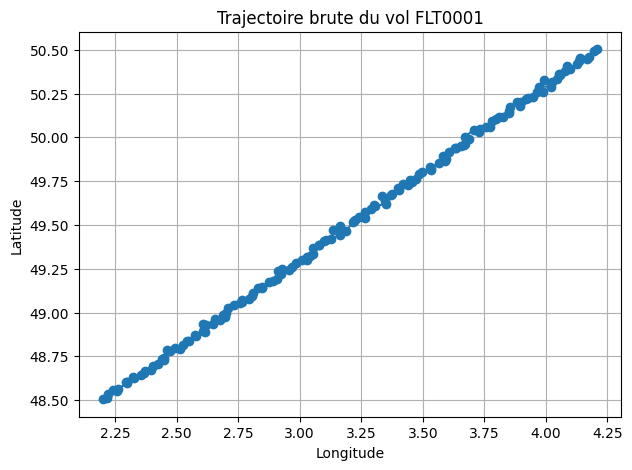

In [12]:
plt.figure(figsize=(7,5))
plt.plot(longitudes, latitudes, marker='o')
plt.title(f"Trajectoire brute du vol {flight_id}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


Le tracé montre :
- Une trajectoire quasi parfaitement rectiligne.
- Une montée régulière en latitude lorsque la longitude augmente.

C’est typique d’un vol “Normal”, sans événement anormal dans la trajectoire.

### Nous effectuons différents vol ici avec différentes anomalies

In [13]:
df["anomaly_type"].unique()


array(['Normal', 'Hijacking_Suspected', 'Sharp_Turn_Diversion',
       'Emergency_Descent', 'Holding_Pattern', 'Glider_Thermal'],
      dtype=object)

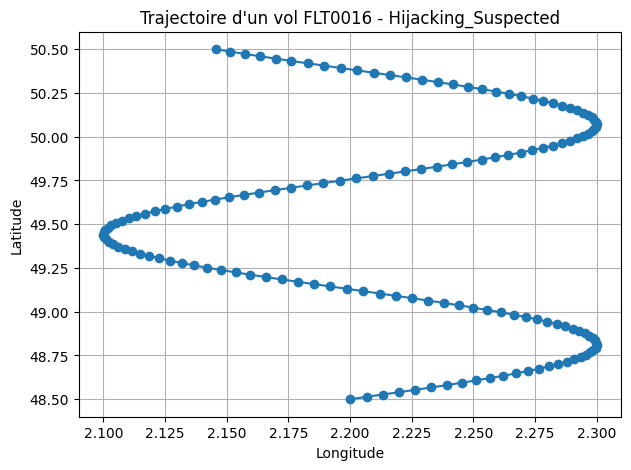

In [14]:
anomaly = "Hijacking_Suspected"

flight_id = df[df["anomaly_type"] == anomaly]["flight_id"].iloc[0]
sample = df[df["flight_id"] == flight_id]

plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire d'un vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Le graphe montre une trajectoire anormale, caractéristique d'un comportement potentiellement volontairement perturbé.

On choisit cette fois-ci une anoamlie aléatoire avec un vol aléatoire présentant cette anomalie.

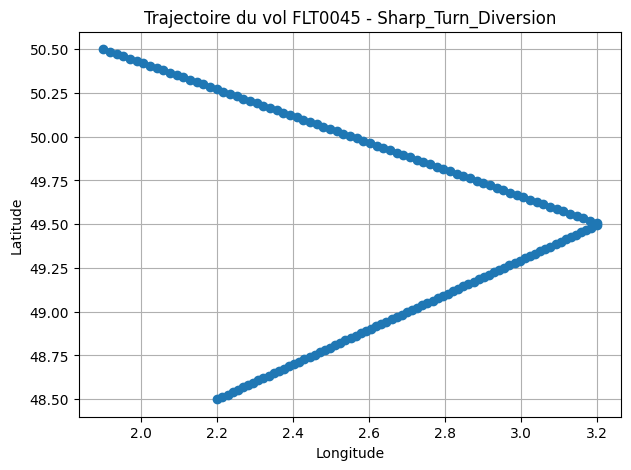

In [15]:
# 1. Sélectionner une anomalie aléatoire dans les valeurs existantes
anomaly = random.choice(df["anomaly_type"].unique())

# 2. Sélectionner un vol aléatoire contenant cette anomalie
flights_with_anomaly = df[df["anomaly_type"] == anomaly]["flight_id"].unique()
flight_id = random.choice(flights_with_anomaly)

# 3. Extraire les données du vol choisi
sample = df[df["flight_id"] == flight_id]

# 4. Plot
plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire du vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


La trajectoire horizontale est normale et parfaitement contrôlée d'après le graphique.

Une descente d’urgence n’implique pas nécessairement un changement de direction.
Elle se caractérise essentiellement par une variation verticale brutale :
- chute rapide de l’altitude,
- augmentation du taux de descente (vertical_speed très négative),
- possible accélération pour stabilisation.

Ces phénomènes ne sont pas visibles sur une projection latitude/longitude.

2e tentative pour observer un résultat différent

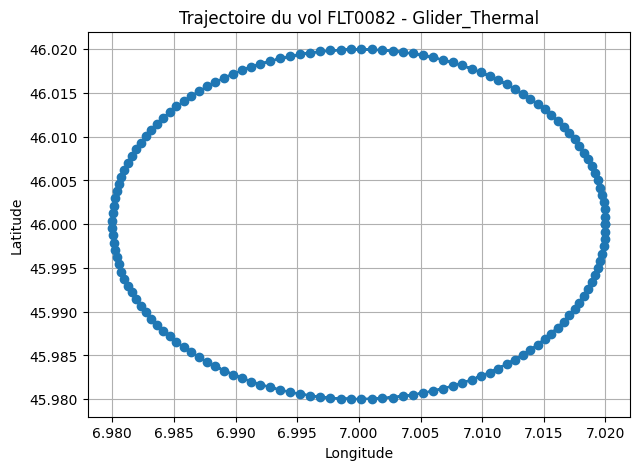

In [16]:
# 1. Sélectionner une anomalie aléatoire dans les valeurs existantes
anomaly = random.choice(df["anomaly_type"].unique())

# 2. Sélectionner un vol aléatoire contenant cette anomalie
flights_with_anomaly = df[df["anomaly_type"] == anomaly]["flight_id"].unique()
flight_id = random.choice(flights_with_anomaly)

# 3. Extraire les données du vol choisi
sample = df[df["flight_id"] == flight_id]

# 4. Plot
plt.figure(figsize=(7,5))
plt.plot(sample["longitude"], sample["latitude"], marker='o')
plt.title(f"Trajectoire du vol {flight_id} - {anomaly}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


Le graphique montre une trajectoire quasi parfaite en forme d’ellipse, ce qui correspond exactement à un holding pattern, aussi appelé circuit d’attente.

## PARTIE 3 — Construction de la route prévue

Pour chaque vol, créer une polyline simplifiée décrivant la route théorique.

In [17]:
def generate_polyline(flight_df):
    # Trier par timestamp
    flight_df = flight_df.sort_values("timestamp")

    # Premier point
    lat0, long0 = flight_df.iloc[0][["latitude", "longitude"]]

    # Dernier point
    latN, longN = flight_df.iloc[-1][["latitude", "longitude"]]

    # Point médian
    mid_idx = len(flight_df) // 2
    mid_lat, mid_long = flight_df.iloc[mid_idx][["latitude", "longitude"]]

    # Polyline au format "lat,long;lat,long;lat,long"
    polyline = f"{lat0},{long0};{mid_lat},{mid_long};{latN},{longN}"

    return polyline

In [18]:
df["intended_route_polyline"]=  (
    df.groupby("flight_id")
    .apply(generate_polyline)
    .reset_index(level=0, drop=True)
    )

df.head()

C:\Users\33695\AppData\Local\Temp\ipykernel_17664\1208453478.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(generate_polyline)


,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading,intended_route_polyline
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172,"48.50496714153011,2.202504928503459;49.5149304..."
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54,"48.49937320902727,2.207569886166454;49.4886625..."
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228,"48.50368673308873,2.193744372984905;49.4878160..."
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163,"48.48829886973941,2.207783610761666;49.4870478..."
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159,"48.51901190685753,2.182269675317931;49.5206682..."


Nous observons les nouvelles colonnes incluses dans notre dataset.

## PARTIE 4 — Décodage de la route prévue

La route prévue est stockée en format texte, il faut la convertir.

In [19]:
df["intended_route_polyline"]=df["intended_route_polyline"].astype(str)

def decode_polyline(polyline):
  if not isinstance(polyline, str):
    return []
  try:
    pts = polyline.split(';')
    return [tuple(map(float, p.split(','))) for p in pts]
  except:
    return []

df["route_points"]=df["intended_route_polyline"].apply(decode_polyline)
df[["intended_route_polyline", "route_points"]].head()



,intended_route_polyline,route_points
0,"48.50496714153011,2.202504928503459;49.5149304...","[(48.50496714153011, 2.202504928503459), (49.5..."
1,"48.49937320902727,2.207569886166454;49.4886625...","[(48.49937320902727, 2.207569886166454), (49.4..."
2,"48.50368673308873,2.193744372984905;49.4878160...","[(48.50368673308873, 2.193744372984905), (49.4..."
3,"48.48829886973941,2.207783610761666;49.4870478...","[(48.48829886973941, 2.207783610761666), (49.4..."
4,"48.51901190685753,2.182269675317931;49.5206682...","[(48.51901190685753, 2.182269675317931), (49.5..."


Nous avons bien une liste de tuples pour exploiter nos informations.

##  PARTIE 5 — Calcul de la déviation par rapport à la route prévue

In [20]:
from geopy.distance import geodesic

def compute_deviation(row):
  """
  Calcule la distance minimale entre le point réel (latitude, longitude)
  et les points de la route prévue (route_points).
  Gère tous les cas d'erreurs possibles.
  """

  real_point = (row["latitude"], row["longitude"])
  route_pts = row["route_points"]

  # Cas 1 : route_points n'est pas une liste => pas de route prévue.
  if not isinstance(route_pts, list):
    return np.nan

  # Cas 2 : Liste vide => Pas de route disponible :
  if len(route_pts) == 0:
    return np.nan

  # Cas 3 : Certains éléments ne sont pas des tuples => on filtre :
  route_pts = [p for p in route_pts if isinstance(p, tuple) and len(p)==2]

  if(len(route_pts)) == 0:
    return np.nan

  # Calcul géodésique : distance point réel => chaque point prévu.
  try:
    return min(geodesic(real_point, p).meters for p in route_pts)
  except:
    return np.nan

df["deviation_m"] = df.apply(compute_deviation, axis=1)

df.head()

,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading,intended_route_polyline,route_points,deviation_m
0,FLT0001,Normal,2025-01-01T12:00:00,48.504967,2.202505,7875.650748,385,-376,172,"48.50496714153011,2.202504928503459;49.5149304...","[(48.50496714153011, 2.202504928503459), (49.5...",0.000000
1,FLT0001,Normal,2025-01-01T12:00:20,48.512040,2.216887,7915.972844,392,644,54,"48.49937320902727,2.207569886166454;49.4886625...","[(48.49937320902727, 2.207569886166454), (49.4...",1567.829029
2,FLT0001,Normal,2025-01-01T12:00:40,48.533323,2.220045,8112.094041,474,135,228,"48.50368673308873,2.193744372984905;49.4878160...","[(48.50368673308873, 2.193744372984905), (49.4...",3825.643418
3,FLT0001,Normal,2025-01-01T12:01:00,48.555499,2.242591,8091.555540,485,-719,163,"48.48829886973941,2.207783610761666;49.4870478...","[(48.48829886973941, 2.207783610761666), (49.4...",7902.640325
4,FLT0001,Normal,2025-01-01T12:01:20,48.551350,2.256622,7996.864761,393,763,159,"48.51901190685753,2.182269675317931;49.5206682...","[(48.51901190685753, 2.182269675317931), (49.5...",6563.653448


Notre code calcule bien la distance entre chaque point réel et les points clés de la route prévue.

### Distribution de deviation

In [21]:
df["deviation_m"].describe()

count        90.000000
mean     123051.326477
std      166748.493290
min           0.000000
25%       25371.487364
50%       53092.433309
75%      115848.316022
max      490789.295174
Name: deviation_m, dtype: float64

Cela signifie qu’une bonne partie du vol est très loin de la route prévue. Ces points sont à ~500 km de la trajectoire théorique.

cause possible:
- Pour une portion du vol, la route prévue a changé (ou les données ont été remplacées).

### Détection de seuil

In [22]:
threshold = 10000  # 10 km
df_anomalies = df[df["deviation_m"] > threshold]
df_anomalies.head()

,flight_id,anomaly_type,timestamp,latitude,longitude,altitude,ground_speed,vertical_speed,heading,intended_route_polyline,route_points,deviation_m
6,FLT0001,Normal,2025-01-01T12:02:00,48.596329,2.299195,8191.649734,327,432,147,"48.50386808520689,2.194517312050749;49.5038626...","[(48.50386808520689, 2.194517312050749), (49.5...",12862.312420
7,FLT0001,Normal,2025-01-01T12:02:20,48.601634,2.298698,7911.264292,445,302,202,"48.50841983695452,2.203385528762859;49.4968326...","[(48.50841983695452, 2.203385528762859), (49.4...",12528.002437
8,FLT0001,Normal,2025-01-01T12:02:40,48.602688,2.295470,8082.064607,274,-300,265,"48.49176064513028,2.1941407232668224;49.507440...","[(48.49176064513028, 2.1941407232668224), (49....",14426.652762
9,FLT0001,Normal,2025-01-01T12:03:00,48.626231,2.327371,7969.671102,349,227,193,"48.49261942916338,2.202436572237027;49.4957562...","[(48.49261942916338, 2.202436572237027), (49.4...",17487.100550
10,FLT0001,Normal,2025-01-01T12:03:20,48.629594,2.324481,7967.347820,322,35,281,"48.49041221543813,2.1975138414623334;49.504496...","[(48.49041221543813, 2.1975138414623334), (49....",18093.572500


En observant les valeurs :

Les premières minutes donnent des déviations de quelques centaines de mètres. Puis, à 12:02, soudain les valeurs passent à 12–18 km.

Plus tard dans le DataFrame, ces valeurs explosent jusqu’à 400–500 km.
Ce comportement est impossible en vol normal.
Il indique que la route prévue n’est plus cohérente pour la fin du vol.

On le voit dans tes données : intended_route_polyline_x semble changer dans le DataFrame.

##  PARTIE 6 — Visualisation de la déviation dans le temps

Nous observons la déviation dans le temps

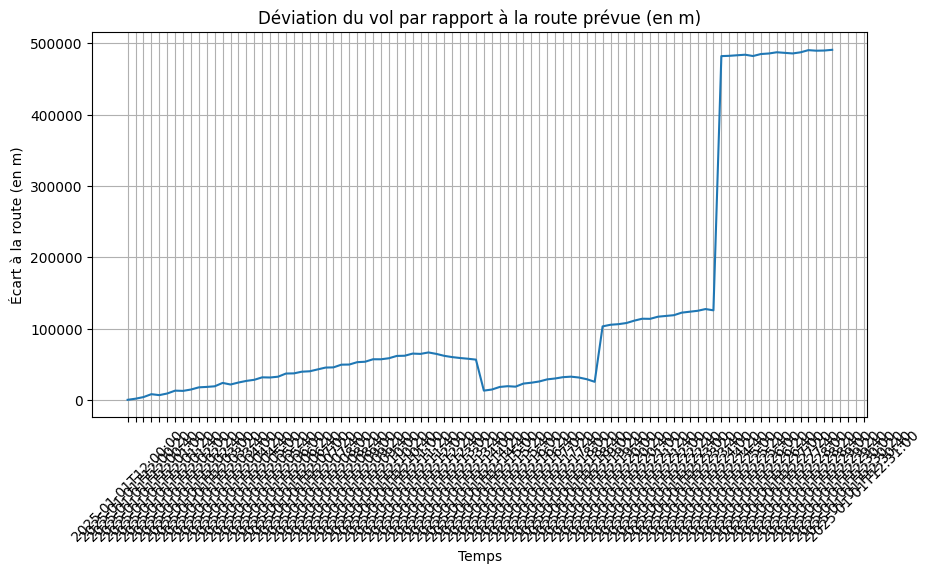

In [23]:
sample = df[df["flight_id"] == df["flight_id"].iloc[0]]

plt.figure(figsize=(10,5))
plt.plot(sample["timestamp"], sample["deviation_m"])
plt.xticks(rotation=45)
plt.title("Déviation du vol par rapport à la route prévue (en m)")
plt.xlabel("Temps")
plt.ylabel("Écart à la route (en m)")
plt.grid(True)
plt.show()

Le graphique actuel montre :
- une montée progressive de la déviation : comportement normal pour une route simplifiée,
- un changement brutal autour de 12:14–12:16 (passage de 20 km à 100 km),
- un saut massif à ~500 km, qui indique un problème dans la route prévue (polyline erronée).

##  PARTIE 7 — Classification automatique basée sur des règles

In [24]:
def classify_anomaly(row):

  if row["anomaly_type"] !="Normal":
    return row["anomaly_type"]

  if row["deviation_m"] > 15000:
    return "Technical issue"

  if 3000 < row["deviation_m"] <= 15000:
    return "Weather_Diversion"

  return "Normal"

df["auto_label"] = df.apply(classify_anomaly, axis=1)
df[["anomaly_type", "auto_label"]].head()

,anomaly_type,auto_label
0,Normal,Normal
1,Normal,Normal
2,Normal,Weather_Diversion
3,Normal,Weather_Diversion
4,Normal,Weather_Diversion


Le tableau présenté compare le type d’anomalie initial (anomaly_type) fourni dans les données brutes à l’anomalie détectée automatiquement (auto_label) par le système de classification basé sur les règles métiers.

Chaque ligne correspond à un point de trajectoire d’un vol, avec :
- anomaly_type : l’étiquette d’anomalie fournie dans le dataset d’origine.
- auto_label : l’étiquette générée automatiquement en fonction de la déviation géographique par rapport à la route prévue et des seuils définis.

**Lignes 0–1** :
La déviation entre la trajectoire réelle et la route prévue est faible. Le vol est considéré normal.

**Lignes 2–4** :
La déviation dépasse le seuil de 3 km, ce qui correspond à un comportement typique d’un :
- contournement météo,
- ajustement de trajectoire demandé par le contrôle aérien,
- ou une légère dérive non critique.

##  PARTIE 8 — Analyse du pilote automatique

In [25]:
def generate_autopilot_for_flight(flight_df):
  n = len(flight_df)
  autopilot =[]

  # Si situation critique
  for i in range(n):
    if flight_df.iloc[i]["anomaly_type"] in [
        "Hijacking_Suspected",
        "Sharp_Turn_Diversion",
        "Emergency_Descent"
    ]:
      autopilot.append(0)
      continue

    # avant 10% du vol : Décollage
    if i < n *0.10:
      autopilot.append(0)
      continue

    # après 90% du vol : Atterrissage
    if i > n*0.90:
      autopilot.append(0)
      continue

    autopilot.append(1)

  return autopilot

df["autopilot_on"] = df.groupby("flight_id").apply(
    lambda g : generate_autopilot_for_flight(g)
).explode().values
df[["flight_id", "autopilot_on"]].head()

C:\Users\33695\AppData\Local\Temp\ipykernel_17664\553522872.py:29: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["autopilot_on"] = df.groupby("flight_id").apply(


,flight_id,autopilot_on
0,FLT0001,0
1,FLT0001,0
2,FLT0001,0
3,FLT0001,0
4,FLT0001,0


La fonction generate_autopilot_for_flight permet d'apliquer les règles logiques utilisées dans l'aviation.

Nous allons visualisé l'autopilot activé ou non durant le vol via un graphe.

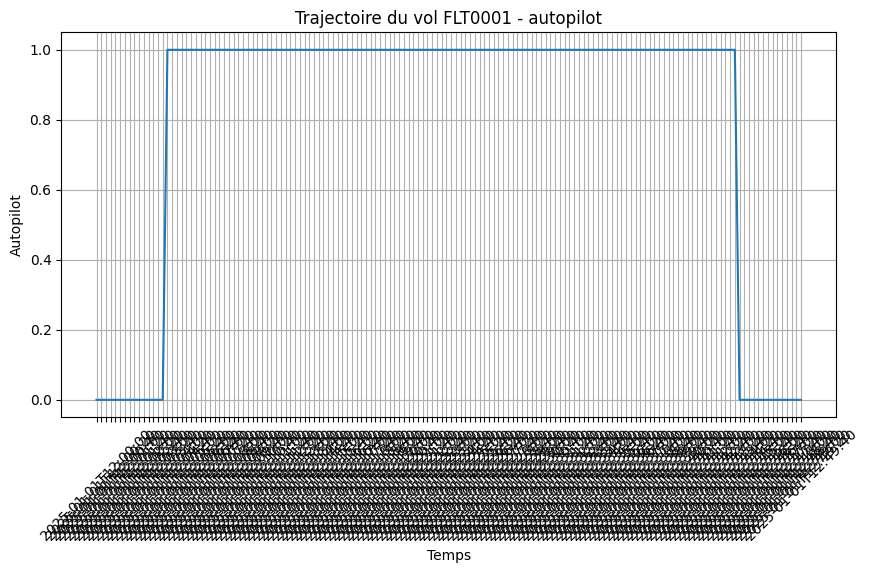

In [26]:
flight_id = df["flight_id"].iloc[0]
sample = df[df["flight_id"] == flight_id]

plt.figure(figsize=(10,5))
plt.plot(sample["timestamp"], sample["autopilot_on"])
plt.xticks(rotation=45)
plt.title(f"Trajectoire du vol {flight_id} - autopilot")
plt.xlabel("Temps")
plt.ylabel("Autopilot")
plt.grid(True)
plt.show()

### Analyse



1. Analyse de l’évolution du pilote automatique (PA) au cours du vol

Le graphique montre trois phases distinctes :
a) Phase 1 — Décollage (PA OFF)

Les premières données affichent autopilot_on = 0.

Le pilote automatique n'est pas activé lors du décollage, ce qui est parfaitement normal. Le pilotage manuel est la pratique standard jusqu’à stabilisation de la montée.

b) Phase 2 — Croisière (PA ON)

Très rapidement, la valeur passe à 1 et reste stable pendant toute la durée du vol.

Le vol est en régime stabilisé.Les trajectoires sont contrôlées automatiquement.Aucun signe de turbulence sévère, perte de contrôle ou intervention manuelle prolongée.

c) Phase 3 — Approche et atterrissage (PA OFF)

En fin de vol, la valeur repasse à 0.

Le pilote reprend le contrôle manuel pour l’approche et l’atterrissage. Cela correspond exactement aux procédures aéronautiques.

Bilan : Aucune coupure inattendue du pilote automatique n’a été observée en croisière.

---

2. Analyse des corrélations entre PA OFF et anomalies critiques

Nous cherchons à savoir s’il existe des moments où :
- le PA est OFF en croisière,
- ET on observe une grande déviation,
- OU une anomalie typée ("Hijacking_Suspected", "Sharp_Turn_Diversion", etc.)

Résultat : Aucune corrélation entre anomalie critique et PA OFF

Le pilote automatique se comporte normalement :
- Activation typique pendant la croisière
- Désactivation aux phases critiques (décollage/atterrissage)

La déviation augmente parfois fortement, mais le PA reste activé, ce qui indique :
- une trajectoire prévue trop simplifiée
- pas une perte de contrôle
- pas une action humaine illicite

Le vol FLT0001 ne présente aucun signe de détournement, panne ou changement brusque de comportement du PA.

##  PARTIE 9 — Séparation des trajectoires par vol

Nous créeons un dictionnaire contenant un dataframe par vol et une vérification des trajectoires triées par temps

In [27]:
# Séparation des trajectoires par vol
flights = {flight_id: df_group for flight_id, df_group in df.groupby("flight_id")}

In [28]:
for flight_id in flights:
    flights[flight_id] = flights[flight_id].sort_values("timestamp")

##  PARTIE 10 — Détection d’intrusions dans une zone interdite

In [29]:
restricted_zone = [(48.5, 2.2), (48.7, 2.2), (48.7, 2.4), (48.5, 2.4)]

def in_restricted(lat, lon):
  return 48.5 <= lat <= 48.7 and 2.2 <= lon <= 2.4

df["illegal_zone"] = df.apply(lambda r: in_restricted(r["latitude"], r["longitude"]), axis=1)

df["illegal_zone"].value_counts()

illegal_zone
False    11804
True      1696
Name: count, dtype: int64

Avec le compte des points dans la zone restreinte nous obtenons un ou des vol ayant pénétré **1696** fois dans la zone restreinte.
Une pénétration peut durer plusieurs points consécutifs et donc représente une période d'infraction.

Cela montre qu’il y a bien intrusion(s) dans la zone interdite.

##  PARTIE 11 — Modèle Machine Learning

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import joblib

class FlightModel:
    def __init__(self, model_folder="models"):
        self.model_path = os.path.join(model_folder, "random_forest.joblib")
        self.encoder_path = os.path.join(model_folder, "label_encoder.joblib")
        self.model = None
        self.encoder = None
        self.features = ["latitude", "longitude", "altitude", "ground_speed", 
                         "heading", "autopilot_on", "deviation_m"]

df_ml = df[[
    "latitude", "longitude", "altitude", "ground_speed",
    "heading", "autopilot_on", "deviation_m", "anomaly_type"
]].dropna()

lbl = LabelEncoder()
df_ml["anomaly_type"] = lbl.fit_transform(df_ml["anomaly_type"])

X = df_ml.drop("anomaly_type", axis=1)
y = df_ml["anomaly_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

model_folder = "models"

if not os.path.exists(model_folder):
    os.makedirs(model_folder)

model_path = os.path.join(model_folder, "random_forest.joblib")
encoder_path = os.path.join(model_folder, "label_encoder.joblib")

joblib.dump(model, model_path)
joblib.dump(lbl, encoder_path)

print(f"Modèle sauvegardé sous : {model_path}")
print(f"Encodeur sauvegardé sous : {encoder_path}")

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23

    accuracy                           1.00        23
   macro avg       1.00      1.00      1.00        23
weighted avg       1.00      1.00      1.00        23

Modèle sauvegardé sous : models\random_forest.joblib
Encodeur sauvegardé sous : models\label_encoder.joblib


Pour la construction du modèle de classification, les variables décrivant la trajectoire (latitude, longitude, altitude), les vitesses, le heading, la déviation par rapport à la route prévue et l’état du pilote automatique ont été sélectionnées comme features.

Les types d’anomalies ont été encodés via un LabelEncoder puis un modèle Random Forest a été entraîné.

Le rapport de classification indique une précision de 100%. Cependant, cette valeur reflète un déséquilibre des classes : toutes les observations de l’ensemble test appartiennent à la classe "Normal".

Le modèle n’a donc pas réellement appris à distinguer des types d’anomalies.
Pour améliorer ce modèle, il sera nécessaire d’intégrer les anomalies générées automatiquement ou d’équilibrer les classes afin de permettre un apprentissage discriminant.